Требуется решить интегральное уравнение первого рода типа Фредгольма.
По заданным функциям K(t,s)=e^(ts/2) и f(t) необходимо найти q(s), 

Решение.
Обозначим: S=3,T=1.
Дискретизируем область [0,S]×[0,T], построив на каждом интервале равномерную сетку для узлов N=N_t=N_S=8,16,32,64,512,1024,2048,4096.
Для вычисления интеграла используем квадратурную формулу Симпосона.
Обозначим:
	A_ij=K(t_i,s_j ) w_j
	q_j=q(s_j)
	f_i=f(t_i )
Получаем СЛАУ : Aq=f

In [1]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

# kernel 
def K(t, s):
    return np.exp((t * s) / 2)

# exact q(s) 
def q_exact(s):
    s = np.asarray(s)
    q = np.zeros_like(s)
    mask1 = (s >= 0) & (s <= 2)
    mask2 = (s > 2) & (s <= 3)
    q[mask1] = (1 - s[mask1] / 2)**2
    q[mask2] = (s[mask2] / 2 - 1)**3
    return q


# weights
def build_weights(a, b, N):
    s = np.linspace(a, b, N)
    h = (b - a) / (N - 1)
    w = np.zeros(N)

    if (N - 1) % 2 == 0:
        w[0] = h/3
        w[1:-1:2] = 4*h/3
        w[2:-1:2] = 2*h/3
        w[-1] = h/3
        method = "Simpson"
    else:
        w[0] = h/2
        w[1:-1] = h
        w[-1] = h/2
        method = "Trapezoid"

    return s, w


# build A
def build_A_simpson(t_grid, s_grid, w):
    T, S = np.meshgrid(t_grid, s_grid, indexing='ij')
    return K(T, S) * w[np.newaxis, :]

# f exact
def compute_f_exact(t_grid, s_grid, w):
    Q = q_exact(s_grid)
    f = np.array([np.sum(K(t, s_grid) * Q * w) for t in t_grid])
    return f

# number of nodes
N_list = [8, 16, 32, 64, 128, 256, 512, 1024,2048]
# N_list = [9, 17, 33, 65, 129, 257, 513, 1025]




1. Исследовать сходимость вычисленного решения к точному решению при увеличении числа узлов сетки. Изучение поведения сингулярных чисел СЛАУ, аппроксимирующей уравнение для разного количества узлов сетки.
Для решения СЛАУ использовался метод SVD.

N,	error,	cond
8	1.10e-05	2.30e+11
16	4.78e+00	5.00e+18
32	9.26e-01	1.66e+16
64	1.96e+00	2.70e+16
128	3.60e+00	4.41e+16
256	4.58e+00	4.30e+16
512	7.83e+00	4.08e+16
1024	4.83e+00	3.20e+16
2048	5.97e+00	4.18e+16


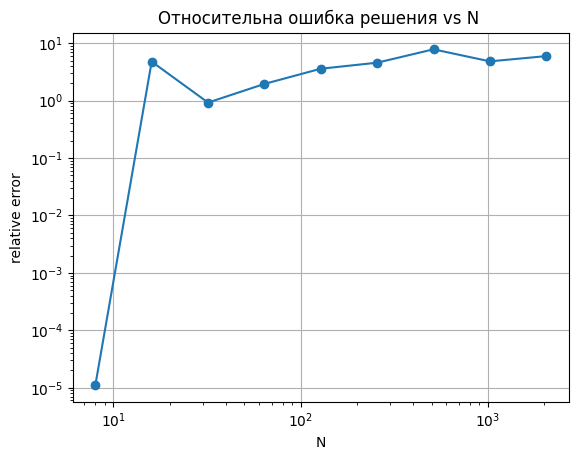

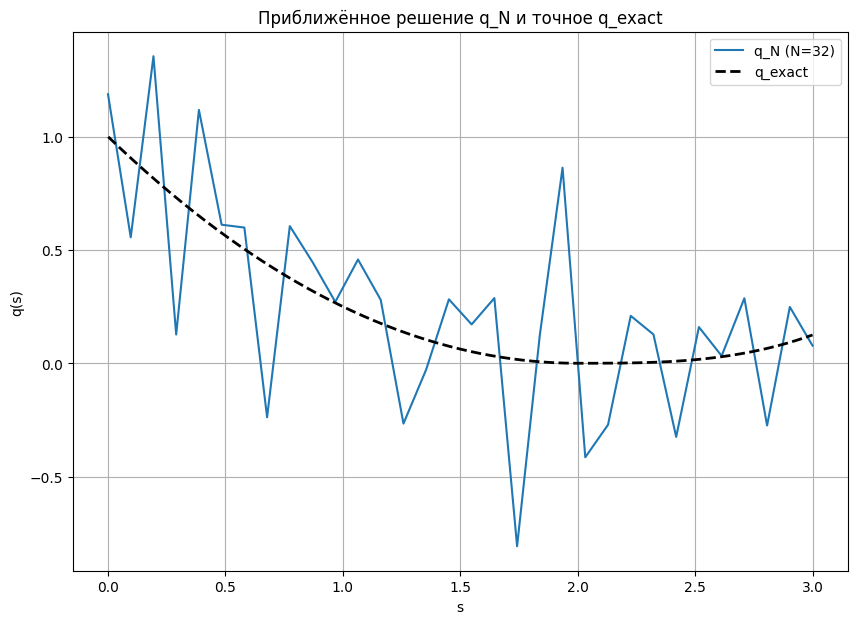

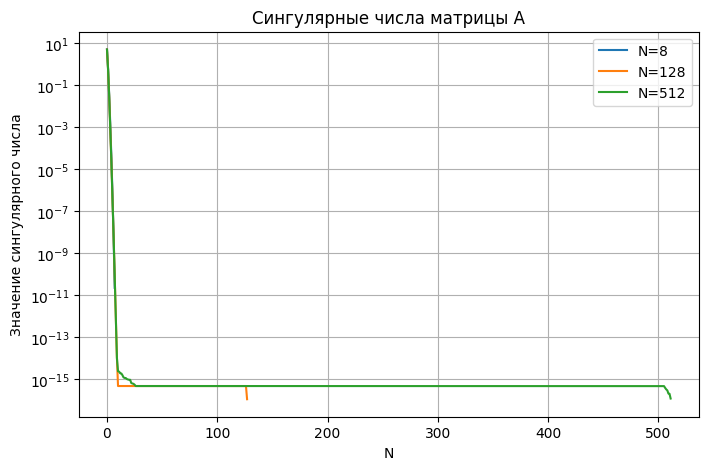

In [5]:
errors = []
conds = []
singulars = {}
solutions = {}

print(f"N,\terror,\tcond")
for N in N_list:

    s_grid, w = build_weights(0, 3, N)

    t_grid = np.linspace(0, 1, N)

    A = build_A_simpson(t_grid, s_grid, w)
    f = compute_f_exact(t_grid, s_grid, w)
    
    U, svals, Vt = la.svd(A, full_matrices=False)
    singulars[N] = svals
    
    s_inv = np.array([1/s for s in svals]) # SVD
    qN = Vt.T @ (s_inv * (U.T @ f))

    solutions[N] = (s_grid, qN)
    
    err = la.norm(qN - q_exact(s_grid)) / la.norm(q_exact(s_grid))
    errors.append(err)
    conds.append(svals[0]/svals[-1])

    print(f"{N}\t{err:.2e}\t{conds[-1]:.2e}")

# Графики относительной ошибки в зависимости от числа узлов
plt.loglog(N_list, errors, '-o')
plt.grid(True)
plt.title("Относительна ошибка решения vs N ")
plt.xlabel("N")
plt.ylabel("relative error")
plt.show()


N_plot = [32]
plt.figure(figsize=(10, 7))
for N in N_plot:
    s_grid, qN = solutions[N]
    plt.plot(s_grid, qN, label=f"q_N (N={N})")
s_fine = np.linspace(0.001, 3, 2000)
plt.plot(s_fine, q_exact(s_fine), 'k--', linewidth=2, label="q_exact")
plt.grid(True)
plt.xlabel("s")
plt.ylabel("q(s)")
plt.title("Приближённое решение q_N и точное q_exact")
plt.legend()
plt.show()

# График сингулярных чисел в зависимости от числа узлов сетки
N_plot = [8,128,512]
plt.figure(figsize=(8,5))
for N in N_plot:
    plt.semilogy(singulars[N], label=f"N={N}")
plt.grid(True)
plt.legend()
plt.xlabel("N")
plt.ylabel("Значение сингулярного числа")
plt.title("Сингулярные числа матрицы A")
plt.show()


1. Исследовать сходимость вычисленного решения к точному решению при увеличении числа узлов сетки. Изучение поведения сингулярных чисел СЛАУ, аппроксимирующей уравнение для разного количества узлов сетки.
Для решения СЛАУ использовался метод TSVD.

N,	error,	cond
8	1.10e-05	2.30e+11
16	3.07e-02	5.00e+18
32	9.99e-02	1.66e+16
64	1.26e-01	2.70e+16
128	1.08e-01	4.41e+16
256	8.36e-02	4.30e+16
512	6.05e-02	4.08e+16
1024	6.12e-02	3.20e+16
2048	3.03e-02	4.18e+16


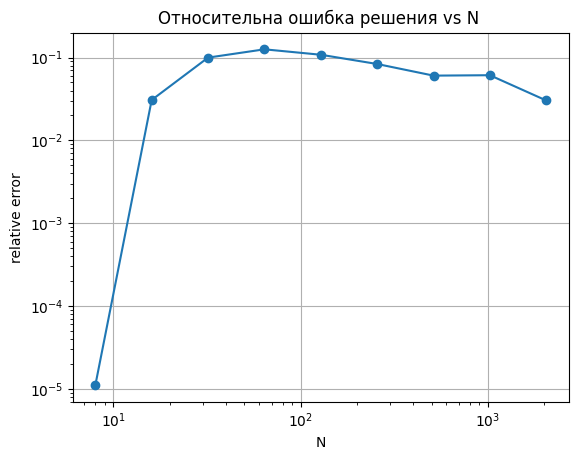

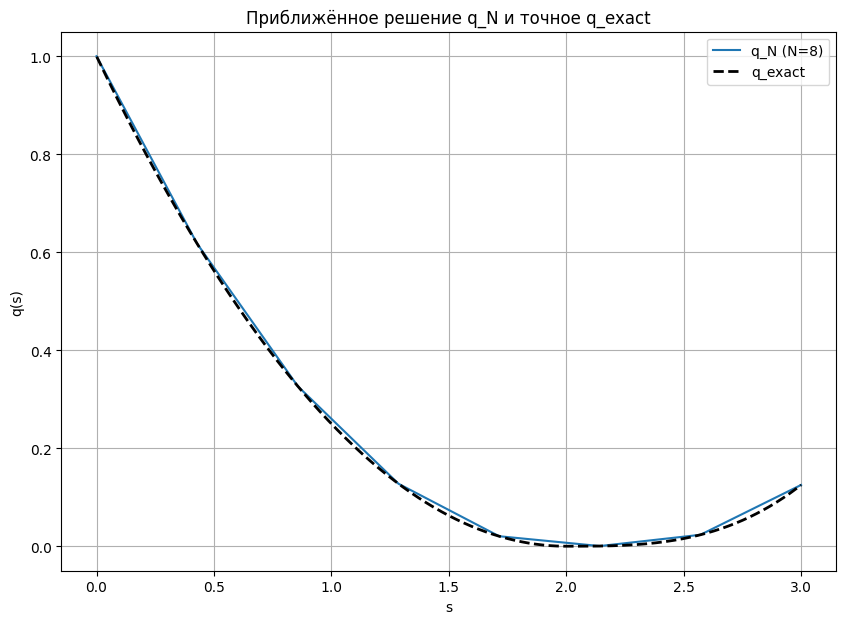

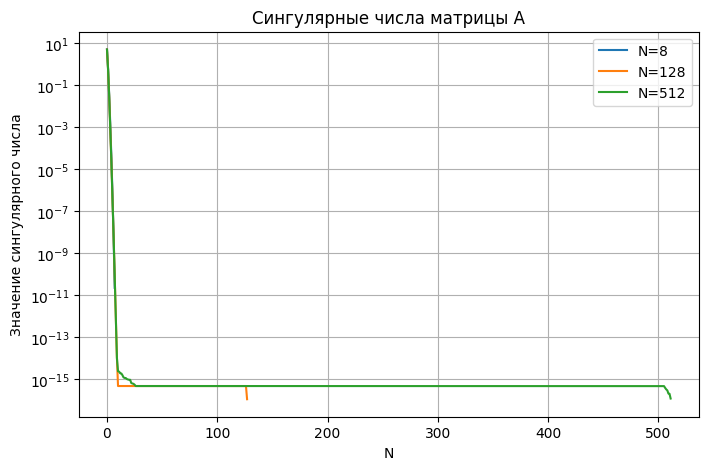

In [26]:
errors = []
conds = []
singulars = {}
solutions = {}

print(f"N,\terror,\tcond")
for N in N_list:

    s_grid, w = build_weights(0, 3, N)

    t_grid = np.linspace(0, 1, N)

    A = build_A_simpson(t_grid, s_grid, w)
    f = compute_f_exact(t_grid, s_grid, w)
    
    U, svals, Vt = la.svd(A, full_matrices=False)
    singulars[N] = svals

    rcond = 1e-15
    bound = rcond * svals[0]
    s_inv = np.array([1/s if s > bound else 0 for s in svals]) # TSVD
    qN = Vt.T @ (s_inv * (U.T @ f))

    solutions[N] = (s_grid, qN)
    
    err = la.norm(qN - q_exact(s_grid)) / la.norm(q_exact(s_grid))
    errors.append(err)
    conds.append(svals[0]/svals[-1])

    print(f"{N}\t{err:.2e}\t{conds[-1]:.2e}")

# Графики относительной ошибки в зависимости от числа узлов
plt.loglog(N_list, errors, '-o')
plt.grid(True)
plt.title("Относительна ошибка решения vs N ")
plt.xlabel("N")
plt.ylabel("relative error")
plt.show()


N_plot = [8]
plt.figure(figsize=(10, 7))
for N in N_plot:
    s_grid, qN = solutions[N]
    plt.plot(s_grid, qN, label=f"q_N (N={N})")
s_fine = np.linspace(0.001, 3, 2000)
plt.plot(s_fine, q_exact(s_fine), 'k--', linewidth=2, label="q_exact")
plt.grid(True)
plt.xlabel("s")
plt.ylabel("q(s)")
plt.title("Приближённое решение q_N и точное q_exact")
plt.legend()
plt.show()

# График сингулярных чисел в зависимости от числа узлов сетки
N_plot = [8,128,512]
plt.figure(figsize=(8,5))
for N in N_plot:
    plt.semilogy(singulars[N], label=f"N={N}")
plt.grid(True)
plt.legend()
plt.xlabel("N")
plt.ylabel("Значение сингулярного числа")
plt.title("Сингулярные числа матрицы A")
plt.show()


Спектр при N = 32

Исследование спектра матрицы A

5.000e+00
5.435e-01
2.826e-02
9.279e-04
2.261e-05
4.402e-07
7.164e-09
1.001e-10
1.216e-12
1.295e-14
4.802e-16
4.802e-16
4.802e-16
4.802e-16
4.802e-16
4.802e-16
4.802e-16
4.802e-16
4.802e-16
4.802e-16
4.802e-16
4.802e-16
4.802e-16
4.802e-16
4.802e-16
4.802e-16
4.802e-16
4.802e-16
4.802e-16
4.802e-16
4.802e-16
3.004e-16


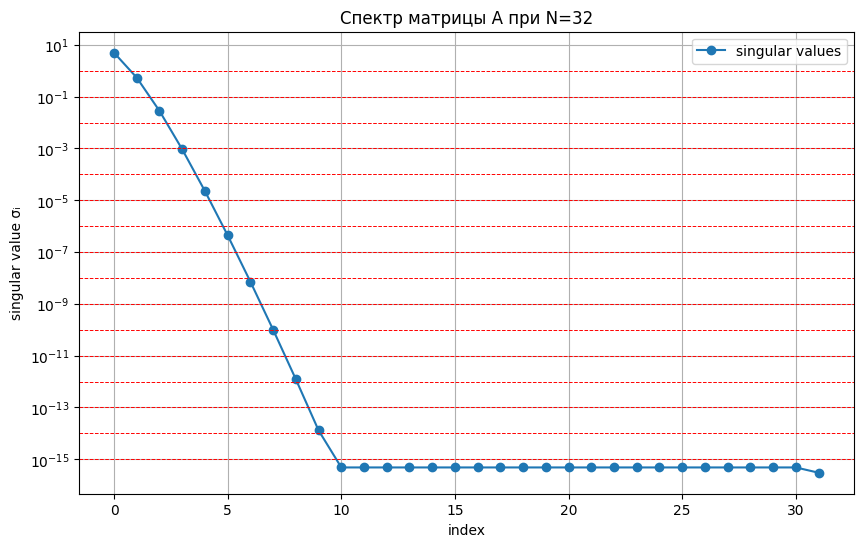

In [ ]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

N_spec = 32

# сетки
s_grid, w = build_weights(0, 3, N_spec)
t_grid = np.linspace(0, 1, N_spec)

# матрица A
A = build_A_simpson(t_grid, s_grid, w)

# SVD спектр
U, svals, Vt = la.svd(A, full_matrices=False)

# график спектра 
plt.figure(figsize=(10,6))
plt.semilogy(svals, 'o-', label='singular values')
for val in svals:
    print(f"{val:.3e}")  

levels = [10**k for k in range(-15, 1)]
for lv in levels:
    plt.axhline(lv, color='red', linestyle='--', linewidth=0.7)

plt.title(f"Спектр матрицы A при N={N_spec}")
plt.xlabel("index")
plt.ylabel("singular value σᵢ")
plt.grid(True, which='both')
plt.legend()
plt.show()


2. Исследовать зависимость численного решения при добавлении шума в данные (рассмотреть уровни шума 0.5, 1, 3 процента) (при фиксированном количестве узлов сетки).

Уровень шума (%) 	 Относительная ошибка
0.5%	6.28e+12
1.0%	1.22e+13
3.0%	4.07e+13


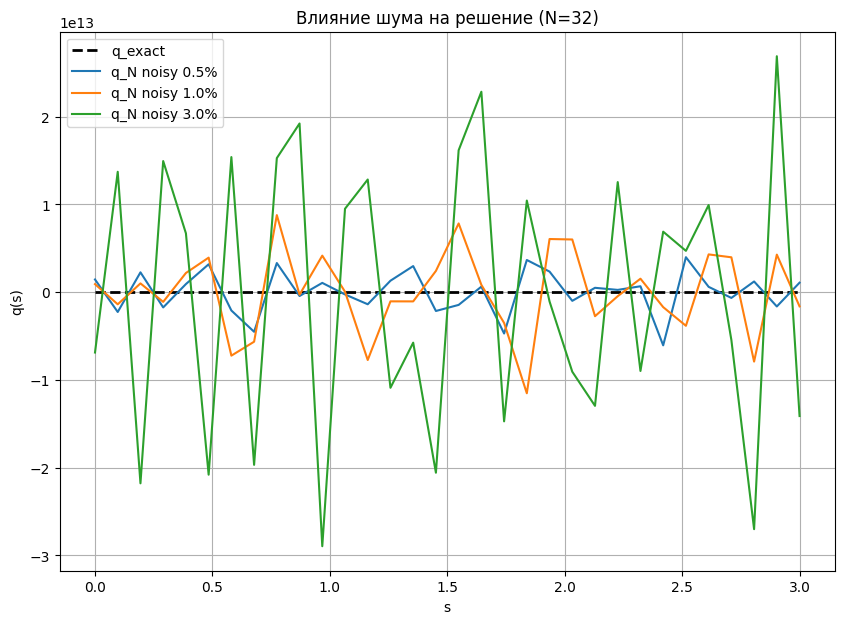

In [6]:

N_noise = 32

noise_levels = [0.005, 0.01, 0.03]  # 0.5%, 1%, 3%

s_grid, w = build_weights(0, 3, N_noise)
t_grid = np.linspace(0, 1, N_noise)

# матрица A и точный f
A = build_A_simpson(t_grid, s_grid, w)
f_exact = compute_f_exact(t_grid, s_grid, w)

U, svals, Vt = la.svd(A, full_matrices=False)

# rcond = 1e-15
# bound = rcond * svals[0]
# s_inv = np.array([1/s if s > bound else 0 for s in svals]) # TSVD

s_inv = np.array([1/s for s in svals]) # SVD


print("Уровень шума (%) \t Относительная ошибка")
np.random.seed(0)
solutions_noisy = {}
for delta in noise_levels:
    alpha = np.random.rand(N_noise)
    f_noisy = f_exact + delta * alpha
    qN_noisy = Vt.T @ (s_inv * (U.T @ f_noisy))
    solutions_noisy[delta] = qN_noisy
    
    err = la.norm(qN_noisy - q_exact(s_grid)) / la.norm(q_exact(s_grid))
    print(f"{delta*100:.1f}%\t{err:.2e}")


plt.figure(figsize=(10,7))
plt.plot(s_grid, q_exact(s_grid), 'k--', linewidth=2, label="q_exact")
for nl, qN_noisy in solutions_noisy.items():
    plt.plot(s_grid, qN_noisy, label=f"q_N noisy {nl*100:.1f}%")
plt.xlabel("s")
plt.ylabel("q(s)")
plt.title(f"Влияние шума на решение (N={N_noise})")
plt.grid(True)
plt.legend()
plt.show()




3. Показать результат применения метода усечённого сингулярного разложения (рассмотреть для уровней шума в 0.5 и 3 процента). Изучить поведение решение и ошибки в зависимости от параметра, отвечающего за границу отсечения сингулярных значений.

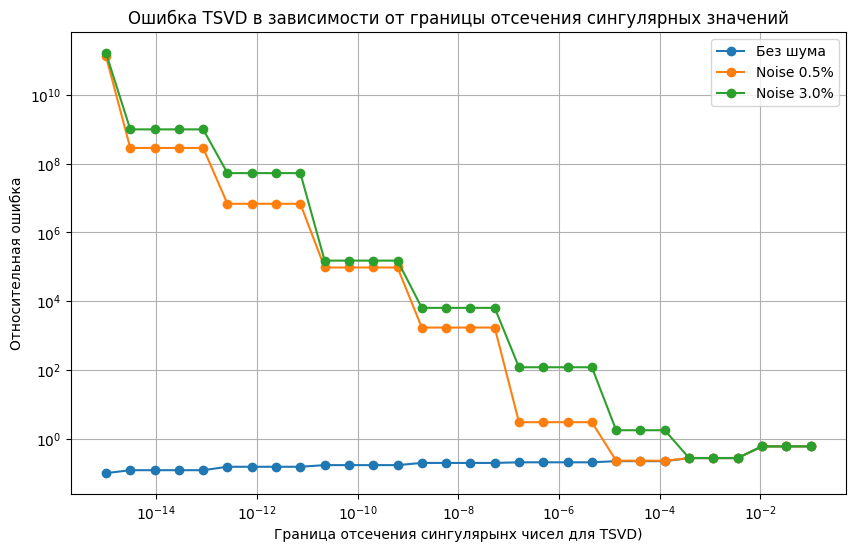


 Значение границы отсечения сингулярных чсиел при минимальной относительной ошибке
Без шума: rcond = 1.000e-15, error = 9.987e-02
Noise 0.5%: rcond = 1.374e-05, error = 2.291e-01
Noise 3.0%: rcond = 3.857e-04, error = 2.755e-01


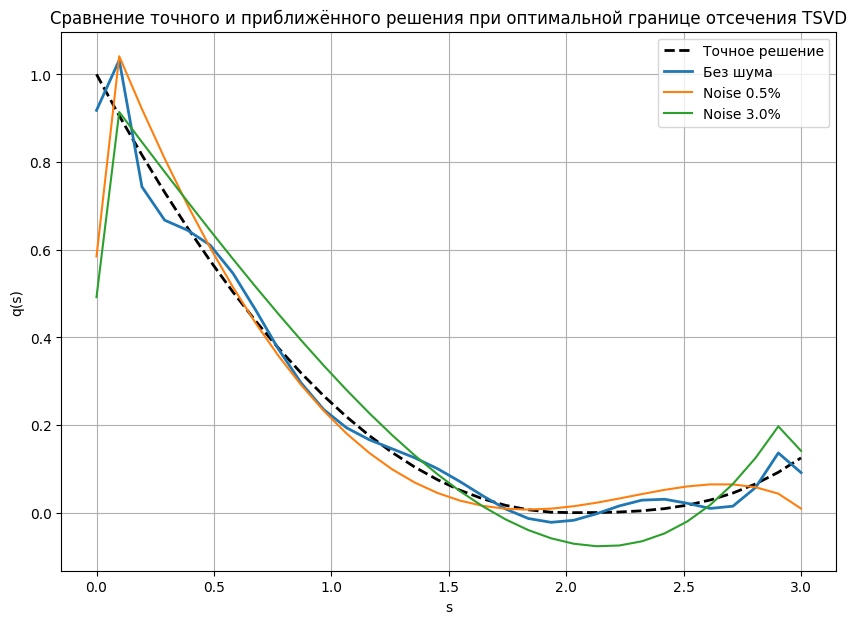

In [ ]:
N_noise = 32
noise_levels = [0.005, 0.03]  # 0.5% и 3%

s_grid, w = build_weights(0, 3, N_noise)
t_grid = np.linspace(0, 1, N_noise)

A = build_A_simpson(t_grid, s_grid, w)
f_exact = compute_f_exact(t_grid, s_grid, w)

# SVD
U, svals, Vt = la.svd(A, full_matrices=False)

np.random.seed(0)
f_noisy_dict = {}
for delta in noise_levels:
    alpha = np.random.rand(N_noise)
    f_noisy_dict[delta] = f_exact + delta * alpha

noise_levels_extended = ["clean"] + noise_levels
f_noisy_dict["clean"] = f_exact.copy()

# диапазон границы отсечения сингулярынх чисел
rcond_list = np.logspace(-15, -1, 30)
errors_dict = {key: [] for key in noise_levels_extended}

for key in noise_levels_extended:
    f_in = f_noisy_dict[key]
    for rcond in rcond_list:
        bound = rcond * svals[0]
        s_inv = np.array([1/s if s > bound else 0 for s in svals])
        qN = Vt.T @ (s_inv * (U.T @ f_in))
        err = la.norm(qN - q_exact(s_grid)) / la.norm(q_exact(s_grid))
        errors_dict[key].append(err)

plt.figure(figsize=(10,6))

plt.loglog(rcond_list, errors_dict["clean"], '-o', label="Без шума")
for delta in noise_levels:
    plt.loglog(rcond_list, errors_dict[delta], '-o', label=f"Noise {delta*100:.1f}%")

plt.xlabel("Граница отсечения сингулярынх чисел для TSVD)")
plt.ylabel("Относительная ошибка")
plt.title("Ошибка TSVD в зависимости от границы отсечения сингулярных значений")
plt.grid(True, which="both")
plt.legend()
plt.show()

# Поиск оптимальной границы отсечения сингулярных числе (минимум относительный ошибки)
optimal_rcond = {}
optimal_solution = {}
optimal_error = {}

for key in noise_levels_extended:
    idx = np.argmin(errors_dict[key])
    r_opt = rcond_list[idx]
    optimal_rcond[key] = r_opt
    
    f_in = f_noisy_dict[key]
    bound = r_opt * svals[0]
    s_inv_opt = np.array([1/s if s > bound else 0 for s in svals])
    q_opt = Vt.T @ (s_inv_opt * (U.T @ f_in))
    
    optimal_solution[key] = q_opt
    optimal_error[key] = errors_dict[key][idx]

print("\n Значение границы отсечения сингулярных чсиел при минимальной относительной ошибке")
print(f"Без шума: rcond = {optimal_rcond['clean']:.3e}, error = {optimal_error['clean']:.3e}")
for delta in noise_levels:
    print(f"Noise {delta*100:.1f}%: rcond = {optimal_rcond[delta]:.3e}, error = {optimal_error[delta]:.3e}")

plt.figure(figsize=(10,7))

plt.plot(s_grid, q_exact(s_grid), "k--", linewidth=2, label="Точное решение")

plt.plot(s_grid, optimal_solution["clean"], label="Без шума", linewidth=2)

for delta in noise_levels:
    plt.plot(s_grid, optimal_solution[delta], label=f"Noise {delta*100:.1f}%")

plt.xlabel("s")
plt.ylabel("q(s)")
plt.grid(True)
plt.title("Сравнение точного и приближённого решения при оптимальной границе отсечения TSVD")
plt.legend()
#plt.xlim(0, 3)
plt.show()


4. Показать результат применения метода регуляризации А.Н.Тихонова  при разных значениях параметра регуляризации.

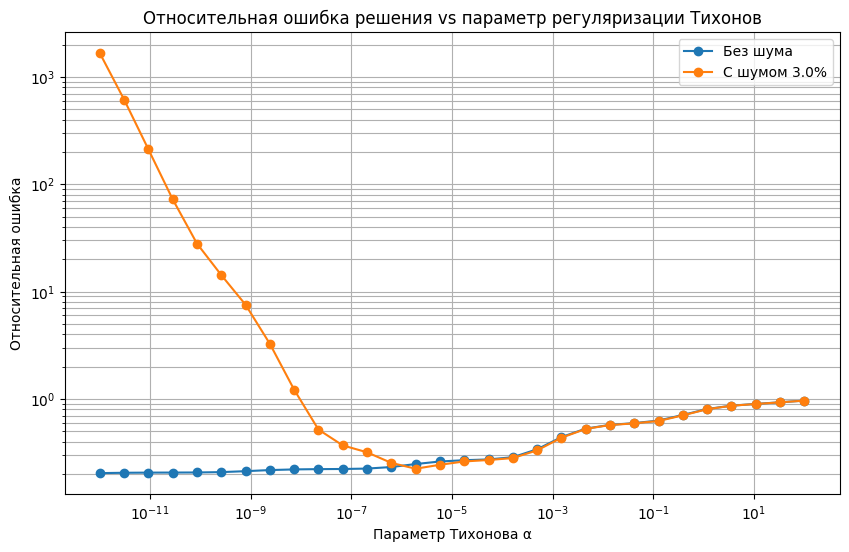

Оптимальный α (без шума): 1e-12
Оптимальный α (с шумом): 1.8873918221350995e-06


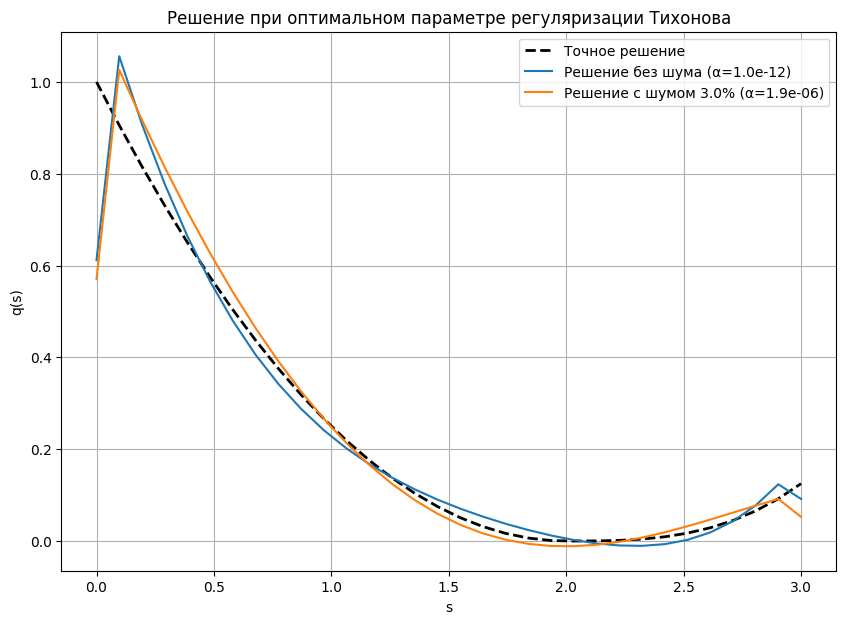

In [ ]:
import numpy as np
import numpy.linalg as la

def tikhonov_svd(U, svals, Vt, f, alpha):
    """
    Вычисляет решение Тихонова через SVD:
    q = V * diag(s/(s^2+alpha)) * U^T f
    """
    Uf = U.T @ f                      
    filt = svals / (svals**2 + alpha)  # фильтр Тихонова
    return (Vt.T @ (filt * Uf))       
  

N_tikh = 32

s_grid, w = build_weights(0, 3, N_tikh)
t_grid = np.linspace(0, 1, N_tikh)

A = build_A_simpson(t_grid, s_grid, w)
f_exact = compute_f_exact(t_grid, s_grid, w)

# SVD разложение A
U, svals, Vt = la.svd(A, full_matrices=False)

noise_level = 0.03   
np.random.seed(0)
alpha_noise = np.random.rand(N_tikh)
f_noisy = f_exact + noise_level * alpha_noise

alpha_list = np.logspace(-12, 2, 30)

errors_exact = []
errors_noisy = []

solutions_exact = {}
solutions_noisy = {}

q_true = q_exact(s_grid)  # точное решение

for alpha in alpha_list:

    # решение без шума
    q_alpha_exact = tikhonov_svd(U, svals, Vt, f_exact, alpha)

    # решение с шумом
    q_alpha_noisy = tikhonov_svd(U, svals, Vt, f_noisy, alpha)

    solutions_exact[alpha] = q_alpha_exact
    solutions_noisy[alpha] = q_alpha_noisy

    err_ex = la.norm(q_alpha_exact - q_true) / la.norm(q_true)
    err_no = la.norm(q_alpha_noisy - q_true) / la.norm(q_true)

    errors_exact.append(err_ex)
    errors_noisy.append(err_no)



 
plt.figure(figsize=(10,6))
plt.loglog(alpha_list, errors_exact, '-o', label="Без шума")
plt.loglog(alpha_list, errors_noisy, '-o', label=f"С шумом {noise_level*100:.1f}%")
plt.xlabel("Параметр Тихонова α")
plt.ylabel("Относительная ошибка")
plt.grid(True, which="both")
plt.title("Относительная ошибка решения vs параметр регуляризации Тихонов")
plt.legend()
plt.show()


# параметр регуляризации, доставляющий минимум относительной ошибке
alpha_opt_exact = alpha_list[np.argmin(errors_exact)]
alpha_opt_noisy = alpha_list[np.argmin(errors_noisy)]

print("Оптимальный α (без шума):", alpha_opt_exact)
print("Оптимальный α (с шумом):", alpha_opt_noisy)


plt.figure(figsize=(10,7))

plt.plot(s_grid, q_exact(s_grid), "k--", linewidth=2, label="Точное решение")

plt.plot(s_grid, solutions_exact[alpha_opt_exact],
         label=f"Решение без шума (α={alpha_opt_exact:.1e})")

plt.plot(s_grid, solutions_noisy[alpha_opt_noisy],
         label=f"Решение с шумом {noise_level*100:.1f}% (α={alpha_opt_noisy:.1e})")

plt.xlabel("s")
plt.ylabel("q(s)")
plt.grid(True)
plt.legend()
plt.title("Решение при оптимальном параметре регуляризации Тихонова")

plt.show()


5. Для уровней шума 0.5, 1 процента построить график невязки и график ошибки решения в зависимости от параметра регуляризации (рассмотреть диапазон α ∈ (10^(-8),10^(-1)) с шагом в 5 или 10 точек в каждом подинтервале 10^(-(i+1) ), 10^i .) Сравнить решение с наименьшей ошибкой, наименьшей невязкой, а также решение, выбранное согласно принципу невязки (Морозова)

In [ ]:
N = 32
noise_levels = [0.005, 0.01]  # 0.5% и 1%


m = 5
alpha_list = []
for k in range(-8, 0):           # подинтервалы 10^k ... 10^(k+1)
    alpha_list.extend(np.logspace(k, k+1, m))
alpha_list = np.array(alpha_list)


s_grid, w = build_weights(0, 3, N)
t_grid = np.linspace(0, 1, N)

A = build_A_simpson(t_grid, s_grid, w)
f_exact = compute_f_exact(t_grid, s_grid, w)
q_ex = q_exact(s_grid)

U, svals, Vt = la.svd(A, full_matrices=False)

np.random.seed(0)
f_noisy_dict = {}
for delta in noise_levels:
    alpha_noise = np.random.rand(N)
    f_noisy_dict[delta] = f_exact + delta * alpha_noise


def tikhonov_solution(alpha, f_noisy):
    """
    q_alpha = V diag(s_i/(s_i^2+alpha)) U^T f
    """
    filt = svals / (svals**2 + alpha)
    return Vt.T @ (filt * (U.T @ f_noisy))


errors = {delta: [] for delta in noise_levels}
residuals = {delta: [] for delta in noise_levels}

for delta in noise_levels:
    f_noisy = f_noisy_dict[delta]

    for alpha in alpha_list:
        q_alpha = tikhonov_solution(alpha, f_noisy)

        # ошибка решения
        err = la.norm(q_alpha - q_ex) / la.norm(q_ex)
        errors[delta].append(err)

        # невязка
        res = la.norm(A @ q_alpha - f_noisy)
        residuals[delta].append(res)


# графики ошибка vs  альфа, невязка vs альфа
for delta in noise_levels:
    plt.figure(figsize=(12,5))

    # ошибка
    plt.subplot(1,2,1)
    plt.loglog(alpha_list, errors[delta], '-o')
    plt.xlabel("параметр регуляризации Тихонова")
    plt.ylabel("Относительная ошибка")
    plt.title(f"Относительная ошибка решения, шум {delta*100:.1f}%")
    plt.grid(True)

    # невязка
    plt.subplot(1,2,2)
    plt.loglog(alpha_list, residuals[delta], '-o')
    plt.xlabel("параметр регуляризации Тихонова")
    plt.ylabel("Невязка ||Aq - f||")
    plt.title(f"Невязка, шум {delta*100:.1f}%")
    plt.grid(True)

    plt.show()



chosen_alpha = {}

for delta in noise_levels:
    f_noisy = f_noisy_dict[delta]

    # минимальная ошибка
    idx_err = np.argmin(errors[delta])
    alpha_min_err = alpha_list[idx_err]

    # минимальная невязка
    idx_res = np.argmin(residuals[delta])
    alpha_min_res = alpha_list[idx_res]

    # Морозов
    delta = f_noisy - f_exact
    target = la.norm(delta) 
    idx_morozov = np.argmin(np.abs(np.array(residuals[delta]) - target))
    alpha_morozov = alpha_list[idx_morozov]

    chosen_alpha[delta] = (alpha_min_err, alpha_min_res, alpha_morozov)

    print(f"\n=== Шум {delta*100:.1f}% ===")
    print(f"α минимальной ошибки   = {alpha_min_err:.3e}")
    print(f"α минимальной невязки   = {alpha_min_res:.3e}")
    print(f"α по Морозову           = {alpha_morozov:.3e}")


for delta in noise_levels:
    f_noisy = f_noisy_dict[delta]
    alpha_min_err, alpha_min_res, alpha_morozov = chosen_alpha[delta]

    plt.figure(figsize=(12,8))

    # точное
    plt.plot(s_grid, q_ex, 'k--', label="q_exact", linewidth=3)

    # три решения
    q1 = tikhonov_solution(alpha_min_err, f_noisy)
    q2 = tikhonov_solution(alpha_min_res, f_noisy)
    q3 = tikhonov_solution(alpha_morozov, f_noisy)

    plt.plot(s_grid, q1, label=f"min error α={alpha_min_err:.1e}")
    plt.plot(s_grid, q2, label=f"min residual α={alpha_min_res:.1e}")
    plt.plot(s_grid, q3, label=f"Morozov α={alpha_morozov:.1e}")

    plt.title(f"Решения Тихонова при шуме {delta*100:.1f}%")
    plt.xlabel("s")
    plt.ylabel("q(s)")
    plt.grid(True)
    plt.legend()
    plt.show()


5. Использование в функционале Тихонова второй производной решения q


=== Noise = 0.5 % ===
α_min_error     = 5.623413251903491e-05
α_min_residual  = 1e-08
α_morozov       = 0.1


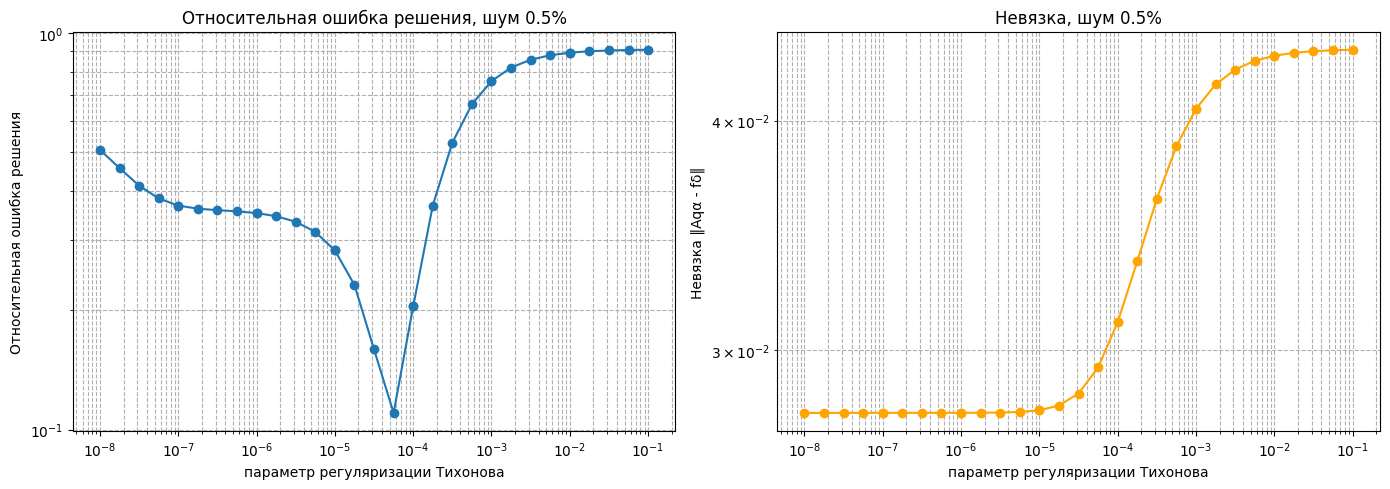

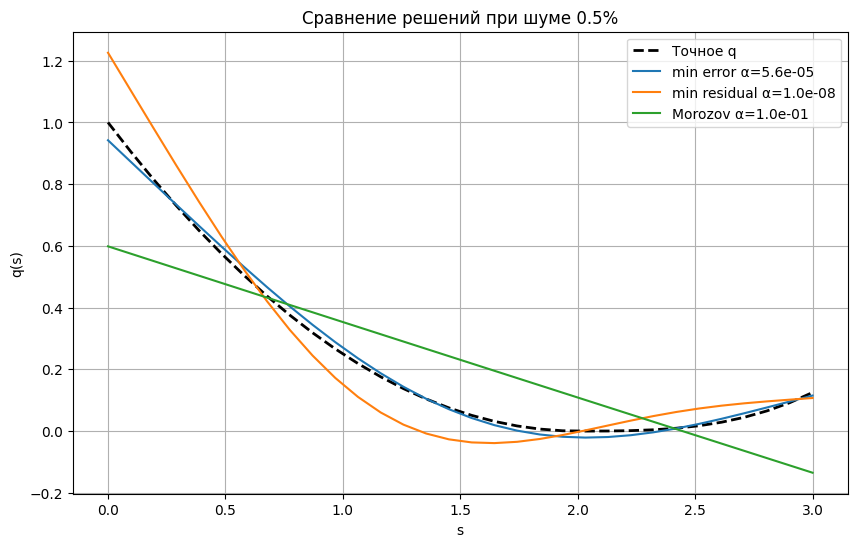


=== Noise = 1.0 % ===
α_min_error     = 0.0001
α_min_residual  = 1e-08
α_morozov       = 0.1


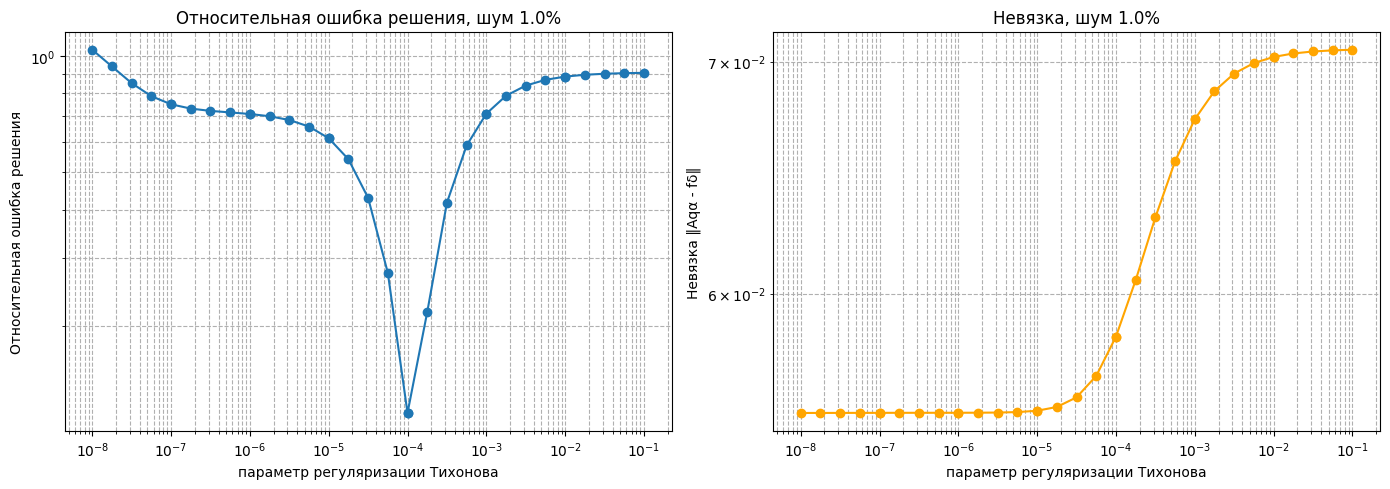

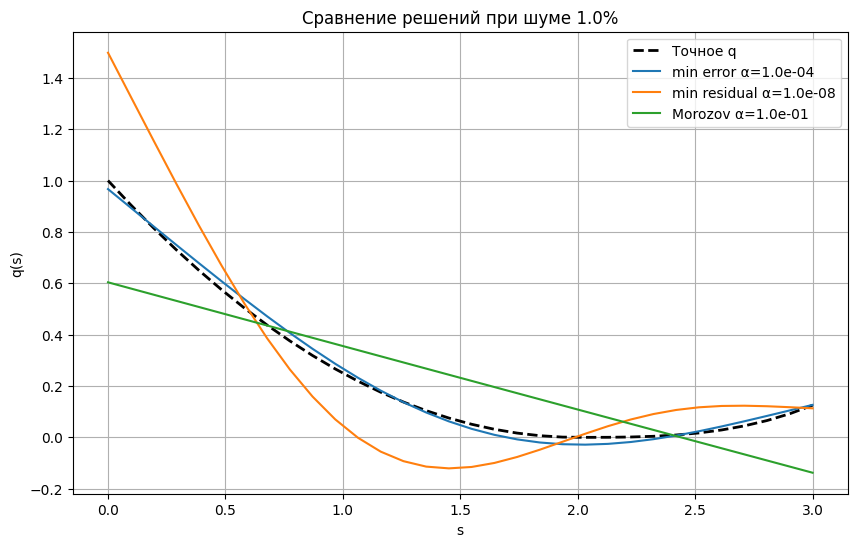

In [21]:

# ---- построение оператора второй производной ----
def build_L2(N, h):
    L = np.zeros((N, N))
    for i in range(1, N-1):
        L[i, i-1] = 1
        L[i, i]   = -2
        L[i, i+1] = 1
    return L / (h*h)

N = 32
noise_levels = [0.005, 0.01]
alpha_list = []

for i in range(-8, -1):
    alpha_list.extend(np.logspace(i, i+1, 5))
alpha_list = np.array(alpha_list)


s_grid, w = build_weights(0, 3, N)
t_grid = np.linspace(0, 1, N)
h = s_grid[1] - s_grid[0]

A = build_A_simpson(t_grid, s_grid, w)
f_exact = compute_f_exact(t_grid, s_grid, w)
q_true = q_exact(s_grid)

L = build_L2(N, h)

# ========== графики для каждого шума ============
for noise in noise_levels:

    np.random.seed(0)
    f_noisy = f_exact + noise*np.random.randn(N)
    noise_norm = la.norm(f_noisy - f_exact)

    errors = []
    residuals = []
    solutions = {}

    ATA = A.T @ A
    LTL = L.T @ L
    ATf = A.T @ f_noisy

    for alpha in alpha_list:
        M = ATA + alpha * LTL
        q_alpha = la.solve(M, ATf)
        solutions[alpha] = q_alpha
        errors.append( la.norm(q_alpha - q_true) )
        residuals.append( la.norm(A @ q_alpha - f_noisy) )

    errors = np.array(errors)
    residuals = np.array(residuals)

    alpha_err = alpha_list[np.argmin(errors)]
    alpha_res = alpha_list[np.argmin(residuals)]
    target = noise_norm * np.sqrt(N)
    idx = np.argmin(np.abs(residuals - target))
    alpha_moro = alpha_list[idx]

    print("\n=== Noise =", noise*100, "% ===")
    print("α_min_error     =", alpha_err)
    print("α_min_residual  =", alpha_res)
    print("α_morozov       =", alpha_moro)

 
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))

    ax1.loglog(alpha_list, errors, '-o')
    ax1.set_xlabel("параметр регуляризации Тихонова")
    ax1.set_ylabel("Относительная ошибка решения")
    ax1.set_title(f"Относительная ошибка решения, шум {noise*100:.1f}%")
    ax1.grid(True, which="both", ls="--")

    ax2.loglog(alpha_list, residuals, '-o', color='orange')
    ax2.set_xlabel("параметр регуляризации Тихонова")
    ax2.set_ylabel("Невязка ‖Aqα - fδ‖")
    ax2.set_title(f"Невязка, шум {noise*100:.1f}%")
    ax2.grid(True, which="both", ls="--")

    plt.tight_layout()
    plt.show()

    # ---- графики решений 
    plt.figure(figsize=(10,6))
    plt.plot(s_grid, q_true, 'k--', lw=2, label="Точное q")
    plt.plot(s_grid, solutions[alpha_err], label=f"min error α={alpha_err:.1e}")
    plt.plot(s_grid, solutions[alpha_res], label=f"min residual α={alpha_res:.1e}")
    plt.plot(s_grid, solutions[alpha_moro], label=f"Morozov α={alpha_moro:.1e}")
    plt.xlabel("s")
    plt.ylabel("q(s)")
    plt.title(f"Сравнение решений при шуме {noise*100:.1f}%")
    plt.grid(True)
    plt.legend()
    plt.show()
